# LOWESS to extract the trend

In this notebook we demonstrate how to use LOWESS to extract a trend from a time series. 

We also show how to use cross-validation to select an appropriate value for the `f` parameter (i.e., the fraction of data to use in a window).

The method was originally proposed in the following paper: 

[1] [Cleveland, William S. "Robust locally weighted regression and smoothing scatterplots." Journal of the American statistical association 74.368 (1979): 829-836.](http://home.eng.iastate.edu/~shermanp/STAT447/Lectures/Cleveland%20paper.pdf)

We will work with a monthly retail sales dataset (found [here](https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv)).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 1, in the folder "01-Create-Datasets" from this repo.

## Data Set Synopsis

The timeseries is collected between January 1992 and May 2016.

It consists of a single series of monthly values representing sales volumes. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

sns.set_context("talk")

# Load data

In [2]:
df = pd.read_csv(
    "../Datasets/example_retail_sales.csv", parse_dates=["ds"], index_col=["ds"]
)

In [3]:
df.head()

,y
ds,
1992-01-01,146376
1992-02-01,147079
1992-03-01,159336
1992-04-01,163669
1992-05-01,170068


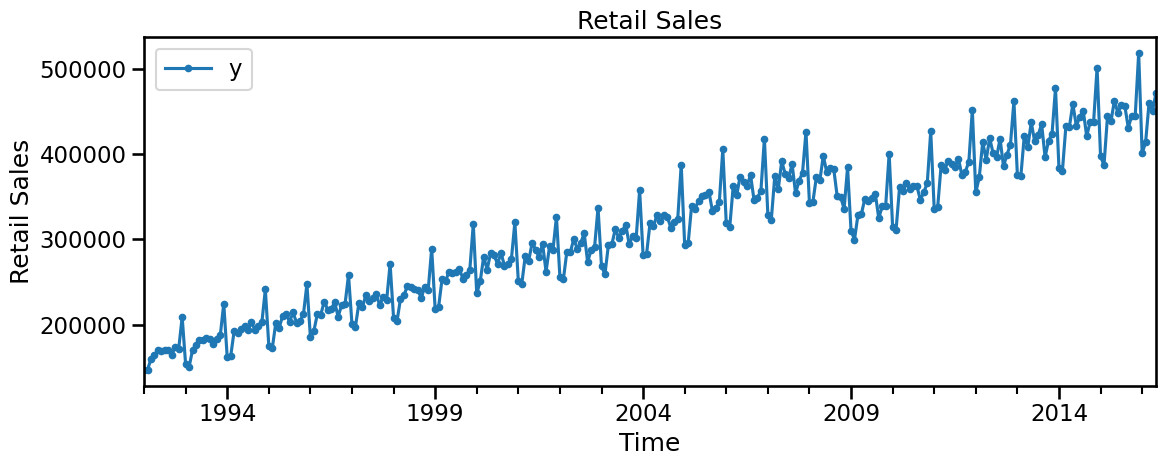

In [4]:
ax = df.plot(marker=".", figsize=[12, 5])
ax.set_xlabel("Time")
ax.set_ylabel("Retail Sales")
ax.set_title("Retail Sales")
plt.tight_layout()

# Use LOWESS to extract trend

In [5]:
df.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01',
               '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01',
               '2016-04-01', '2016-05-01'],
              dtype='datetime64[ns]', name='ds', length=293, freq=None)

In [6]:
# The input of lowess need to be numpy arrays and a numeric type

y = df["y"]
x = np.arange(0, len(y))  # datetime is not a numeric type
# so we use a sequence of integers
# for the x-values for the purpose of fitting

# lowess returns an array where the first column
# are the x values and the second column are the
# values of the fit at those x values

res = lowess(
    endog=y,  # the y values
    exog=x,  # the corresponding x values
    frac=0.1,  # fraction of dataset to use in window
    it=3,  # Number of iterations for robust regression.
    # The default value of 3 is typically good enough [1].
)

res[
    :10,
]

array([[0.00000000e+00, 1.56224386e+05],
       [1.00000000e+00, 1.57578127e+05],
       [2.00000000e+00, 1.58916267e+05],
       [3.00000000e+00, 1.60244262e+05],
       [4.00000000e+00, 1.61568493e+05],
       [5.00000000e+00, 1.62894959e+05],
       [6.00000000e+00, 1.64228160e+05],
       [7.00000000e+00, 1.65570864e+05],
       [8.00000000e+00, 1.66923576e+05],
       [9.00000000e+00, 1.68283960e+05]])

In [7]:
# Append the lowess curve to the original dataframe
df["lowess"] = res[:, 1]

df.head()

,y,lowess
ds,,
1992-01-01,146376,156224.385686
1992-02-01,147079,157578.127266
1992-03-01,159336,158916.267408
1992-04-01,163669,160244.261688
1992-05-01,170068,161568.493429


Text(0.5, 0, 'Time')

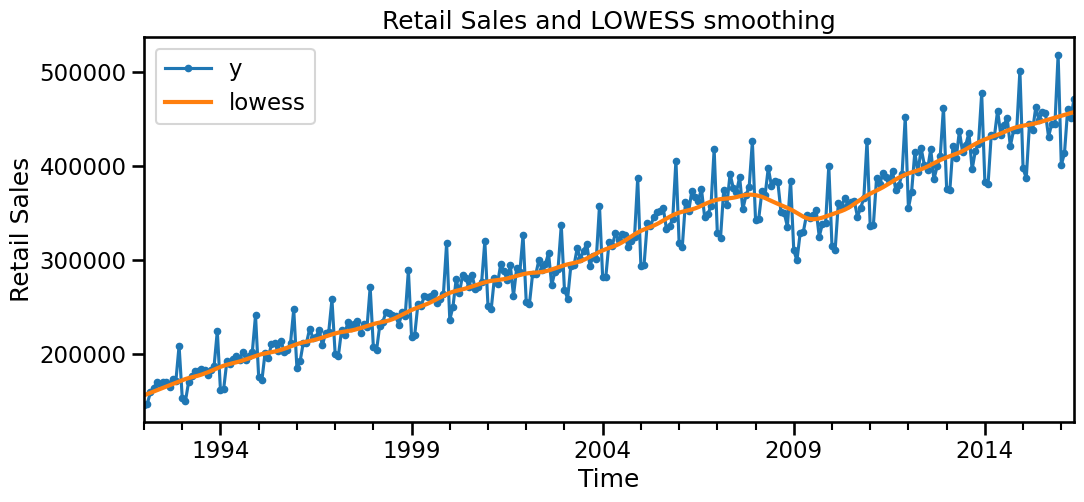

In [8]:
# Plot the fit
fig, ax = plt.subplots(figsize=[12, 5])
df.plot(y="y", marker=".", ax=ax)
df.plot(y="lowess", ax=ax, linewidth=3)
ax.set_title("Retail Sales and LOWESS smoothing")
ax.set_ylabel("Retail Sales")
ax.set_xlabel("Time")

# Exploring the frac parameter

The fraction of data to use in a window in LOWESS determines how smooth the fit is. Let's plot a few examples to illustrate this.

Text(0.5, 0, 'Time')

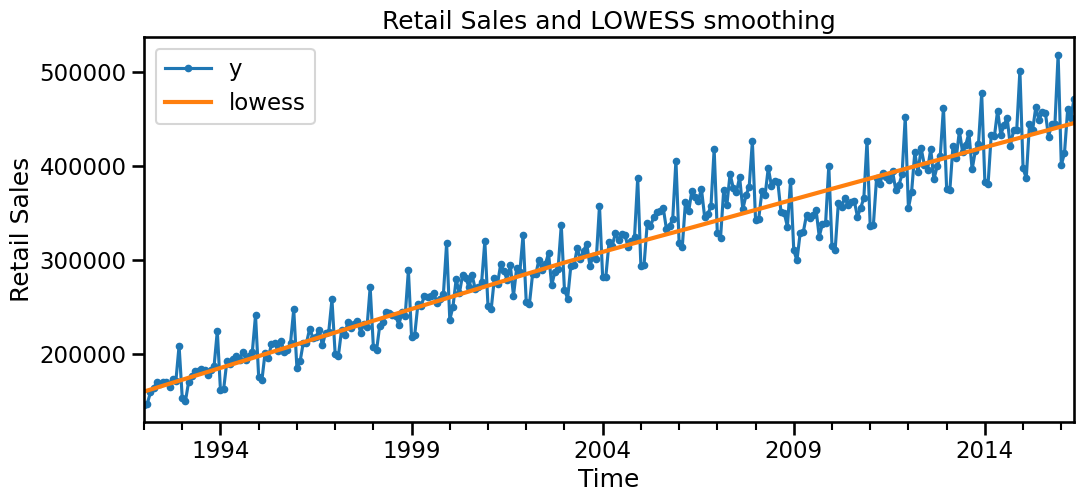

In [9]:
# Too large
frac = 0.9
y = df["y"]
x = np.arange(0, len(y))
res = lowess(endog=y, exog=x, frac=frac)
df["lowess"] = res[:, 1]

# Plot the fit
fig, ax = plt.subplots(figsize=[12, 5])
df.plot(y="y", marker=".", ax=ax)
df.plot(y="lowess", ax=ax, linewidth=3)

ax.set_title("Retail Sales and LOWESS smoothing")
ax.set_ylabel("Retail Sales")
ax.set_xlabel("Time")

Text(0.5, 0, 'Time')

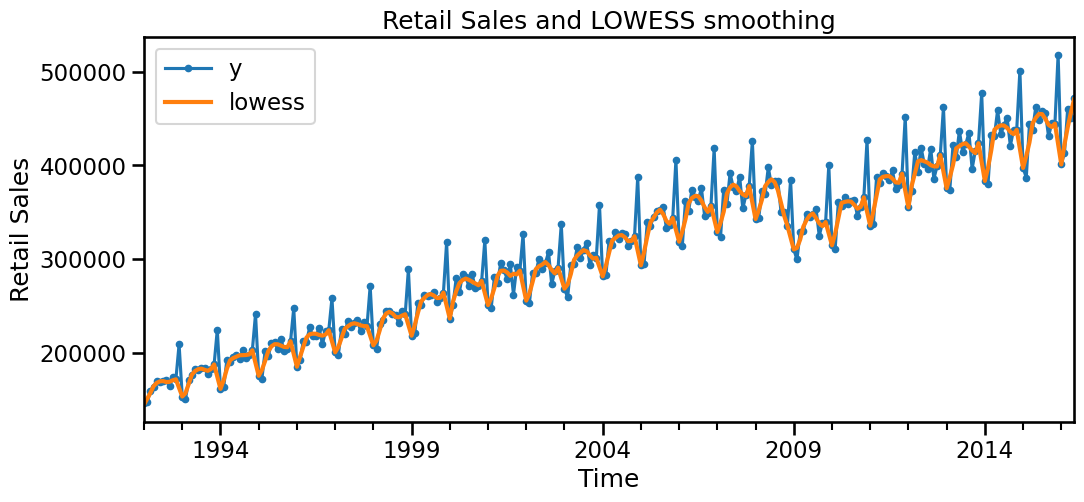

In [10]:
# Too small
frac = 0.02
y = df["y"]
x = np.arange(0, len(y))
res = lowess(endog=y, exog=x, frac=frac)
df["lowess"] = res[:, 1]

# Plot the fit
fig, ax = plt.subplots(figsize=[12, 5])
df.plot(y="y", marker=".", ax=ax)
df.plot(y="lowess", ax=ax, linewidth=3)

ax.set_title("Retail Sales and LOWESS smoothing")
ax.set_ylabel("Retail Sales")
ax.set_xlabel("Time")

Text(0.5, 0, 'Time')

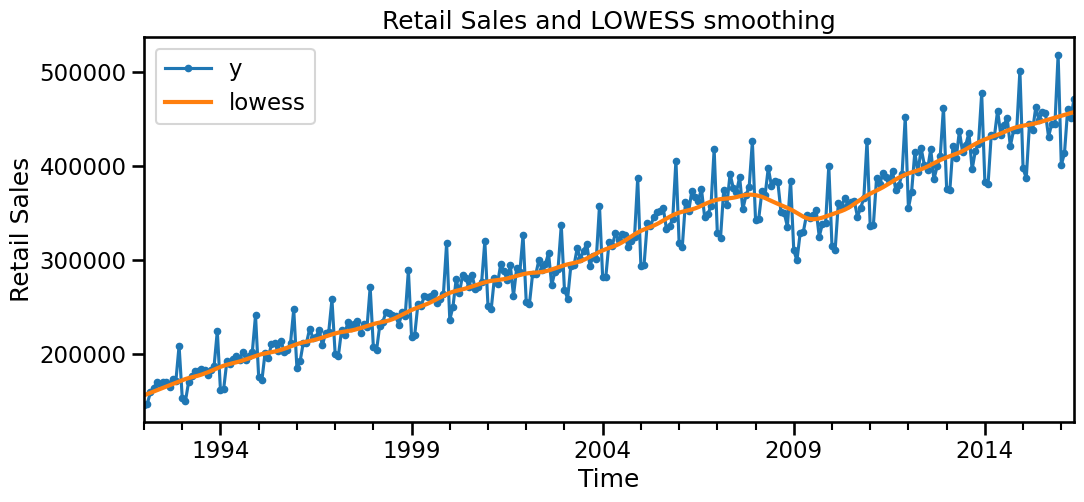

In [11]:
# A good visual fit
frac = 0.1
y = df["y"]
x = np.arange(0, len(y))
res = lowess(endog=y, exog=x, frac=frac)
df["lowess"] = res[:, 1]

# Plot the fit
fig, ax = plt.subplots(figsize=[12, 5])
df.plot(y="y", marker=".", ax=ax)
df.plot(y="lowess", ax=ax, linewidth=3)

ax.set_title("Retail Sales and LOWESS smoothing")
ax.set_ylabel("Retail Sales")
ax.set_xlabel("Time")

The goal in the choice of the `frac` parameter is to select a large a value as possible to minimise the variability in the fit without distorting patterns in the data [1]. This could be done visually. Alternatively, if this process had to be automated we could use K-fold cross validation to optimise a loss function (e.g., RMSE) as a function of `frac`. We demonstrate this below.

# Using K-Fold cross validation to select the `frac` parameter

In K-Fold cross validation we split the data into K evenly sized subsets, called folds. We hold one fold as a hold out set and fit the LOWESS to the data on the remaining K-1 folds. We then evaluate how good the fit is by computing a loss or error metric on the hold out set. We iterate over each fold to obtain K values of the error metric. We can then take an average of the K errors to obtain an estimate of the performance of the fit. In this notebook we use the root mean square error, RMSE.

<img src="https://upload.wikimedia.org/wikipedia/commons/c/c7/LOOCV.gif" alt="Drawing" style="width: 500px;"/>


Source: https://commons.wikimedia.org/wiki/File:LOOCV.gif

In [12]:
from sklearn.model_selection import KFold

In [13]:
# Helper function to compute the RMSE
def rmse(y, yhat):
    e = y - yhat
    return np.sqrt(np.mean(e**2))

In [14]:
cv_score_by_f = dict()  # Initialise an empty dict to store results
X = np.arange(0, len(df), dtype=float)
y = df["y"].values

for f in np.arange(0.04, 1.02, 0.02):  # Scan over values from 0.04 to 1
    cv_results = []  # Initialise list to store the result for each fold
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    for train_index, test_index in kfold.split(X, y):
        # Split the data
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]

        # Compute lowess fit
        y_pred = lowess(
            endog=y_train,  # the y values
            exog=X_train,  # the corresponding x values
            frac=f,  # fraction of dataset to use in window
            xvals=X_test,  # Return fitted values only for specific x values
        )

        # Compute loss function
        loss = rmse(y_test, y_pred)
        cv_results.append(loss)

    # Compute average and standard error across all folds
    cv_score_mean = np.mean(cv_results)
    cv_score_by_f[f] = cv_score_mean


results = pd.Series(cv_score_by_f)  # Convert results to pandas dataframe

In [15]:
results.head()

0.04    23698.959305
0.06    22704.912111
0.08    22392.879583
0.10    22023.141726
0.12    21868.979833
dtype: float64

Text(0, 0.5, 'RMSE')

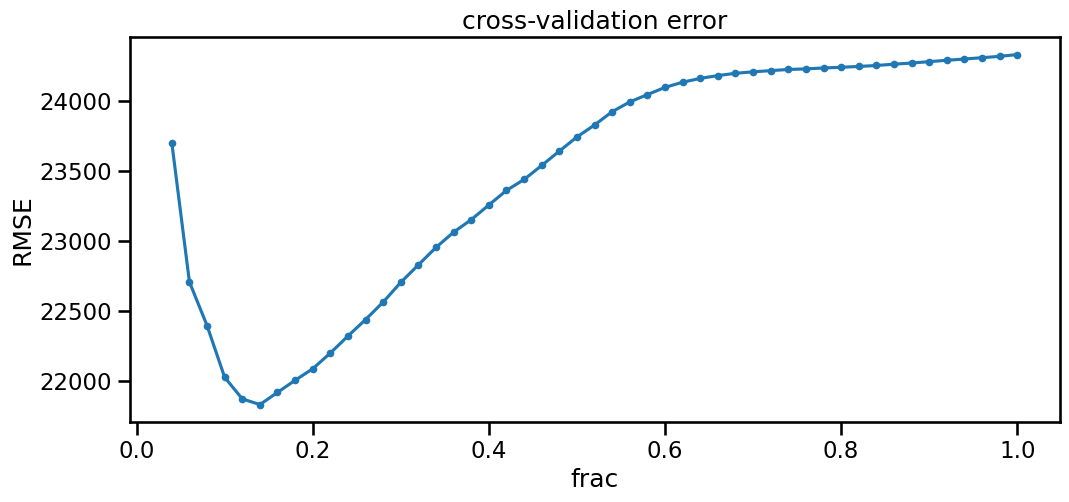

In [16]:
ax = results.plot(marker=".", figsize=[12, 5])
ax.set_xlabel("frac")
ax.set_title("cross-validation error")
ax.set_ylabel("RMSE")

In [17]:
results.index[results.argmin()]

0.13999999999999999

We see that the cross-val error is minimised at approximately `frac=0.14`. Let's plot what this fit looks like.

Text(0.5, 0, 'Time')

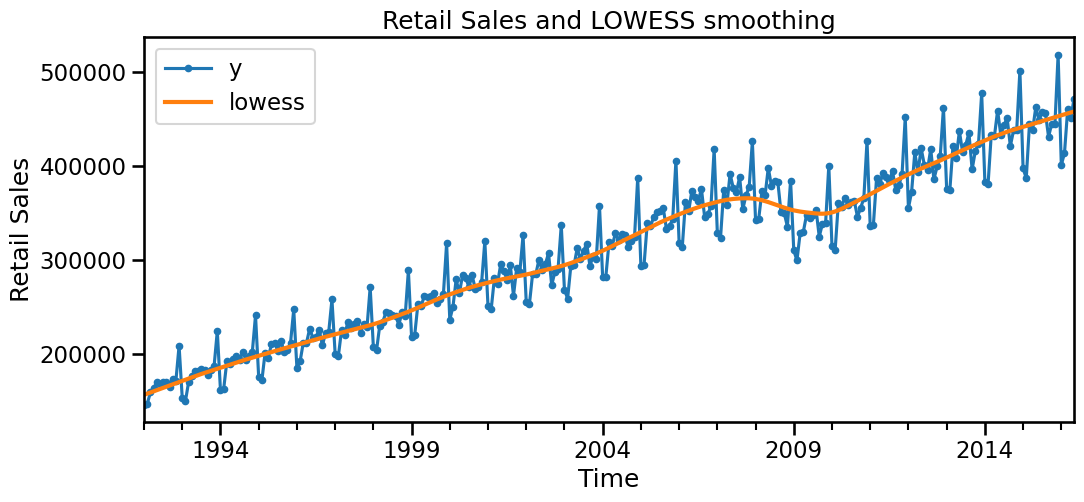

In [18]:
frac = 0.14
y = df["y"]
x = np.arange(0, len(y))
res = lowess(endog=y, exog=x, frac=frac)
df["lowess"] = res[:, 1]

# Plot the fit
fig, ax = plt.subplots(figsize=[12, 5])
df.plot(y="y", marker=".", ax=ax)
df.plot(y="lowess", ax=ax, linewidth=3)

ax.set_title("Retail Sales and LOWESS smoothing")
ax.set_ylabel("Retail Sales")
ax.set_xlabel("Time")

We can see that we can use cross-val to automatically select an appropriate value for the `frac` parameter.